In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Membaca data dari file Excel
data = pd.read_excel("Data Curah Hujan Harian 2022-2024 Cleaned.xlsx", header=0)

# Menetapkan nama kolom secara manual jika kolom 'Tanggal' tidak ditemukan
data.columns = ['ID WMO', 'Curah Hujan', 'Kolom_Tidak_Terpakai', 'Keterangan']

# Menghapus kolom yang tidak relevan
data = data.drop(columns=['Kolom_Tidak_Terpakai', 'Keterangan'])

In [3]:
# Mengonversi 'Curah Hujan' menjadi numerik
data['Curah Hujan'] = pd.to_numeric(data['Curah Hujan'], errors='coerce')

# Mengonversi 'ID WMO' menjadi kolom Tanggal
data['Tanggal'] = pd.to_datetime(data['ID WMO'], errors='coerce')

# Menghapus baris yang mengandung tanggal kosong setelah konversi
data.dropna(subset=['Tanggal'], inplace=True)

C:\Users\muham\AppData\Local\Temp\ipykernel_8924\3940879352.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Tanggal'] = pd.to_datetime(data['ID WMO'], errors='coerce')


In [4]:
# Membuat fitur RR-1, RR-2 (curah hujan sebelumnya dalam 1-2 hari)
for i in range(1, 3):  # Membuat Lag 1 dan Lag 2
    data[f'RR-{i}'] = data['Curah Hujan'].shift(i)

# Menghapus baris yang memiliki nilai kosong setelah pembuatan fitur
data.dropna(inplace=True)

# Menentukan fitur (RR-1, RR-2) dan target ('Curah Hujan')
X = data[['RR-1', 'RR-2']].values  # Fitur dari lag 1 sampai lag 2
y = data['Curah Hujan'].values  # Target (curah hujan)

In [5]:
# Membagi data menjadi data pelatihan (80%) dan data pengujian (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weights = np.random.uniform(-1, 1, (input_size, hidden_size))  # Input weights
        self.biases = np.random.uniform(-1, 1, (1, hidden_size))  # Bias
        self.output_weights = np.random.uniform(-1, 1, (hidden_size, output_size))  # Output weights

    def relu_activation(self, x):
        # ReLU activation function (ensures non-negative output)
        return np.maximum(0, x)

    def train(self, X, y):
        # Calculate the output of the hidden layer using ReLU activation
        H = self.relu_activation(np.dot(X, self.weights) + self.biases)
        H_pseudo_inv = np.linalg.pinv(H)  # Menghitung invers Moore-Penrose
        self.output_weights = np.dot(H_pseudo_inv, y)  # Menghitung bobot output

    def predict(self, X):
        # Compute the hidden layer output with ReLU activation
        H = self.relu_activation(np.dot(X, self.weights) + self.biases)
        # Return the prediction (ensure it's non-negative using ReLU)
        predictions = np.dot(H, self.output_weights)
        # Clip any negative predictions to zero (if any appear due to errors)
        return np.maximum(predictions, 0)

In [7]:
# Initialize the best values with extreme values
best_mae = float('inf')  # Set initial best MAE as infinity (we want to minimize it)
best_mse = float('inf')  # Set initial best MSE as infinity (we want to minimize it)

best_hidden_size_mae = None  # Store the hidden size with the best MAE
best_hidden_size_mse = None  # Store the hidden size with the best MSE

best_elm_mae = None  # Store the best ELM model based on MAE
best_elm_mse = None  # Store the best ELM model based on MSE

# Track performance for different hidden sizes
mae_scores_for_hidden_sizes = []
mse_scores_for_hidden_sizes = []

# Try different hidden sizes and track performance
hidden_sizes = [1, 3, 5, 10, 15, 20, 25, 30]  # List of hidden sizes

In [8]:
for hidden_size in hidden_sizes:
    elm = ELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
    elm.train(X_train, y_train)  # Train the model
    predictions = elm.predict(X_test)  # Predict using the test data

    # Calculate MAE and MSE
    mae = mean_absolute_error(y_test, predictions)  # Mean Absolute Error
    mse = mean_squared_error(y_test, predictions)  # Mean Squared Error
    
    # Store results
    mae_scores_for_hidden_sizes.append(mae)
    mse_scores_for_hidden_sizes.append(mse)
    
    # Track best model based on MAE
    if mae < best_mae:
        best_mae = mae
        best_hidden_size_mae = hidden_size
        best_elm_mae = elm

    # Track best model based on MSE
    if mse < best_mse:
        best_mse = mse
        best_hidden_size_mse = hidden_size
        best_elm_mse = elm

    # Debugging print
    print(f"Hidden Neurons: {hidden_size}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")

# Output the best MAE and MSE models
print(f"\nBest MAE: {best_mae} for Hidden Size: {best_hidden_size_mae}")
print(f"Best MSE: {best_mse} for Hidden Size: {best_hidden_size_mse}")

Hidden Neurons: 1
MAE: 10.895371410799944
MSE: 588.6433262537772
Hidden Neurons: 3
MAE: 11.56737076335875
MSE: 518.2305267472062
Hidden Neurons: 5
MAE: 13.097731472025393
MSE: 814.9570105161131
Hidden Neurons: 10
MAE: 11.325773326483805
MSE: 525.1414546228041
Hidden Neurons: 15
MAE: 11.129492339437624
MSE: 496.51417949955686
Hidden Neurons: 20
MAE: 11.119680684973332
MSE: 511.6434321378954
Hidden Neurons: 25
MAE: 11.224246485662327
MSE: 513.80258663454
Hidden Neurons: 30
MAE: 11.18310424006175
MSE: 510.8029895460911

Best MAE: 10.895371410799944 for Hidden Size: 1
Best MSE: 496.51417949955686 for Hidden Size: 15


In [9]:
# Get predictions from the best model (based on MAE or MSE)
best_predictions = best_elm_mae.predict(X_test)  # Using the best ELM model based on MAE

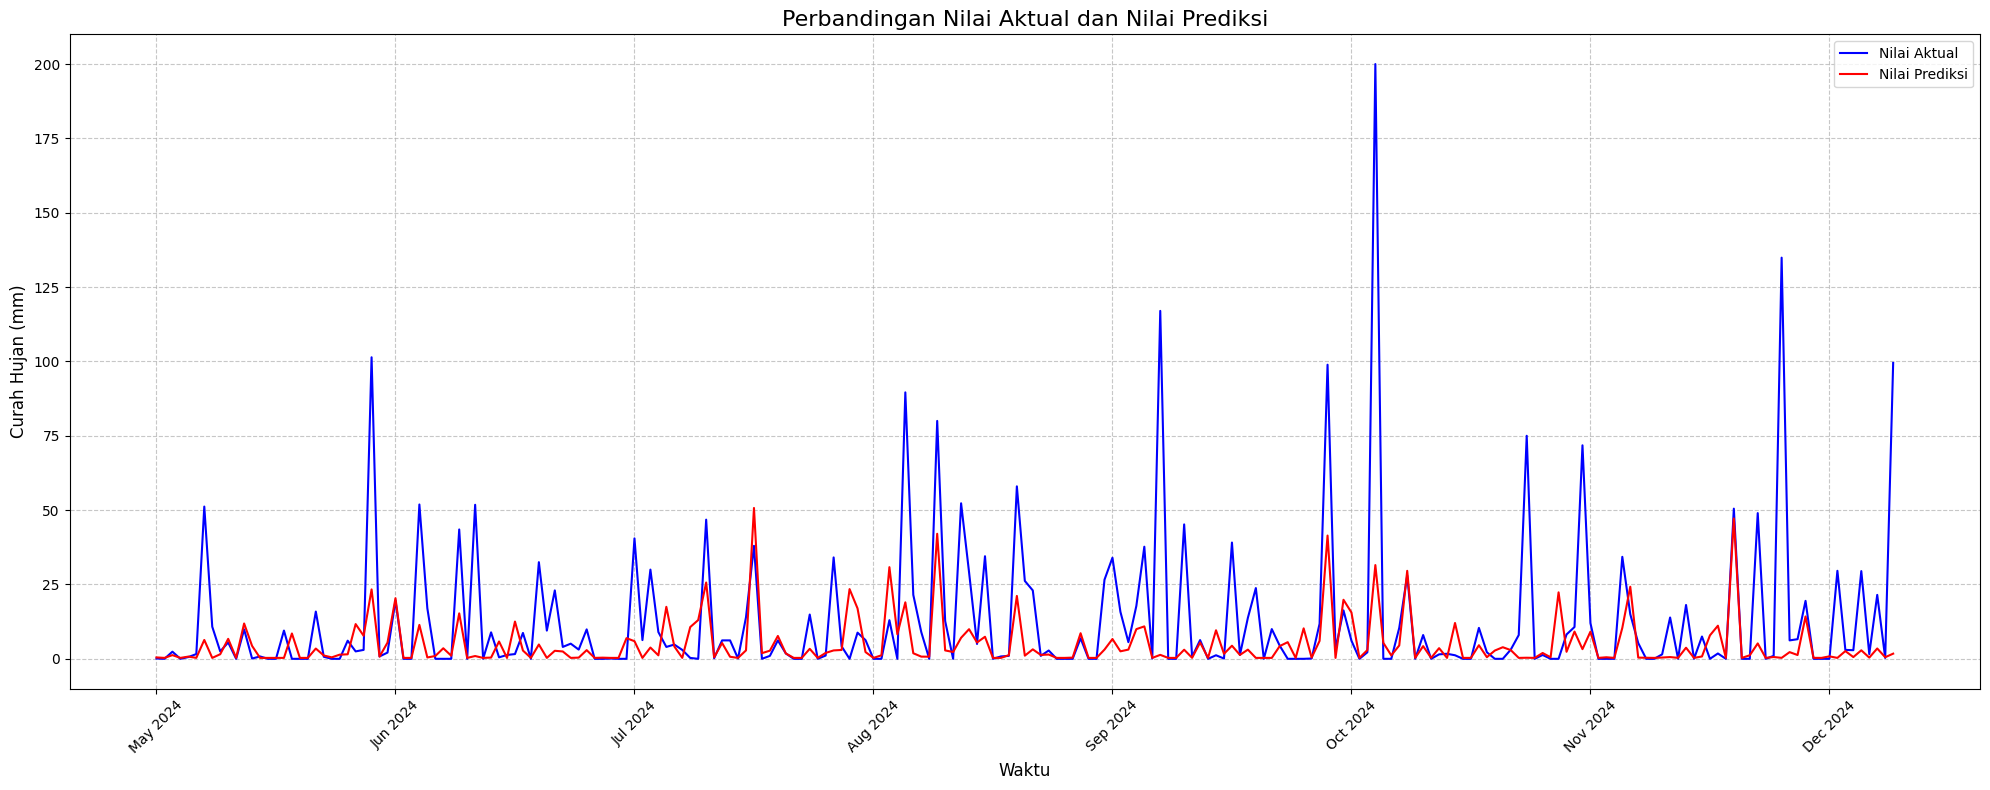

MAE for Best ELM model: 10.895371410799944
MSE for Best ELM model: 496.51417949955686


In [10]:
# Plot the actual vs predicted rainfall for the best ELM model (using MAE)
plt.figure(figsize=(20, 8))

# Plot actual data (blue)
plt.plot(y_test, color='blue', label='Nilai Aktual')

# Plot predictions (red) for the best ELM model
plt.plot(best_predictions, color='red', label='Nilai Prediksi')

# Adding title and labels
plt.title('Perbandingan Nilai Aktual dan Nilai Prediksi', fontsize=16)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Curah Hujan (mm)', fontsize=12)

# Adding Year-Month labels on the X-axis (every 6 months)
dates = data['Tanggal'].iloc[-len(y_test):]  # Ambil tanggal sesuai jumlah data uji
years_months = dates.dt.strftime('%b %Y')  # Format bulan dan tahun

# Display each label per 6 data (to reduce density)
plt.xticks(ticks=np.arange(0, len(dates), step=30), labels=years_months[::30], rotation=45, fontsize=10)

# Adding legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Print the performance metrics (MAE, MSE)
print(f"MAE for Best ELM model: {best_mae}")
print(f"MSE for Best ELM model: {best_mse}")

Text(0.5, 1.0, 'Perbandingan MAE untuk Jumlah Neuron yang Berbeda')

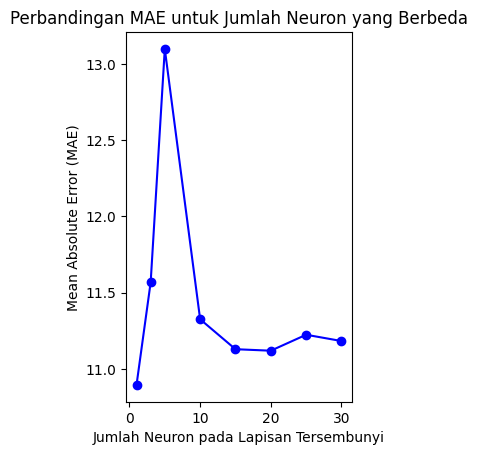

In [11]:
# Grafik MAE
plt.subplot(1, 2, 1)
plt.plot(hidden_sizes, mae_scores_for_hidden_sizes, marker='o', color='blue')
plt.xlabel('Jumlah Neuron pada Lapisan Tersembunyi')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Perbandingan MAE untuk Jumlah Neuron yang Berbeda')

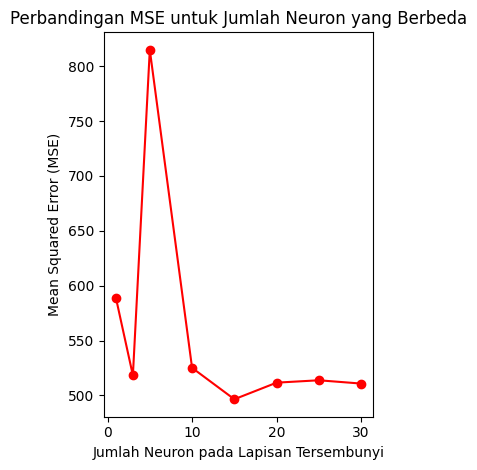

In [12]:
# Grafik MSE
plt.subplot(1, 2, 2)
plt.plot(hidden_sizes, mse_scores_for_hidden_sizes, marker='o', color='red')
plt.xlabel('Jumlah Neuron pada Lapisan Tersembunyi')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Perbandingan MSE untuk Jumlah Neuron yang Berbeda')

plt.tight_layout()
plt.show()